# C1DB1B Workshop 1: Statistical-Based Decision Making

**Welcome!** Today you'll learn Python + Statistics together through real healthcare workforce analysis.

**🎯 Business Scenario:** Planning a new healthcare facility in Västra Götaland - analyze sick leave data to inform staffing and budget decisions.

**✨ By End of Today:**
- [ ] Calculate mean, median, standard deviation (and know when to use each)
- [ ] Create professional visualizations
- [ ] Identify outliers and explain business impact
- [ ] Make data-driven budget recommendations

**📖 Learning Approach:** Theory → Code → Business Decision (repeat)

---
## 🐍 Part 1: Foundations (20 min - Instructor-Led)

### Python Basics: Libraries

**Library = Toolbox of pre-made functions**

| Library | Purpose | Analogy |
|---------|---------|---------|
| `pandas` | Data tables | "Excel for Python" |
| `numpy` | Math operations | "Calculator" |
| `matplotlib` | Basic charts | "Graph paper" |
| `seaborn` | Beautiful charts | "Design software" |
| `scipy` | Statistics | "Stats textbook" |

**Why use libraries?** Don't reinvent the wheel - use expert-built tools.

In [ ]:
# Import libraries (give them short nicknames with 'as')
import pandas as pd          # pd = pandas
import numpy as np           # np = numpy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Configure chart appearance
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("✅ Libraries loaded!")

### Statistics Basics: Three Key Measures

**📊 Before we touch code, understand these concepts:**

**1. Mean (Average)** = Sum ÷ Count
```
Data: [3%, 4%, 5%, 4%, 9%]
Mean = (3+4+5+4+9) ÷ 5 = 5%
Use when: No extreme outliers
```

**2. Median (Middle)** = Middle value when sorted
```
Sorted: [3%, 4%, 4%, 5%, 9%]
Median = 4% (middle value)
Use when: Data has outliers
```

**3. Standard Deviation (Spread)** = How scattered data is
```
Small SD (1%) = Very consistent
Large SD (5%) = Highly variable
```

**📝 Quick Exercise:** Calculate mean & median for [6%, 7%, 8%, 20%]
<details>
<summary>Answer</summary>
Mean = 10.25%, Median = 7.5%  
Notice: Outlier (20%) pulls mean up, median stays stable
</details>

**🤔 Business Question:** For budgeting, would you use mean or median? Why?

### Loading Data: Step-by-Step

**Strategy:** Load messy Excel → Clean → Analyze

**Our Excel structure:**
```
Row 3: Years [2013, 2013, 2013, 2014, 2014...]
Row 4: Gender [Women, Men, Both, Women, Men, Both...]
Row 5+: Job categories with sick leave %
```

**Goal:** Transform to clean table:
| job_category | year | gender | sick_leave_% |

In [43]:
# Install Excel support (run once)
%pip install openpyxl

# File location (change if needed)
file_path = r"C:\Users\gimb\Documents\teaching\c1db1b\2025\practicals\datasets\dataset1_health_staff_sickleave_HR002_20241118-224047.xlsx"

print("📂 Loading data...")

Note: you may need to restart the kernel to use updated packages.
📂 Loading data...


In [44]:
# Load and restructure data (pre-written for you)
try:
    df_raw = pd.read_excel(file_path, sheet_name=0, header=None)
    
    # Extract years and genders from header rows
    years_row = df_raw.iloc[2, 2:].values
    genders_row = df_raw.iloc[3, 2:].values
    
    # Match each year with its three genders
    year_gender_pairs = []
    current_year = None
    for year_val, gender_val in zip(years_row, genders_row):
        if pd.notna(year_val):
            current_year = str(int(float(year_val)))
        if pd.notna(gender_val) and str(gender_val) in ['Kvinna', 'Man', 'Båda könen']:
            if current_year:
                year_gender_pairs.append((current_year, str(gender_val)))
    
    # Extract data rows
    data_rows = []
    for row_idx in range(4, len(df_raw)):
        row = df_raw.iloc[row_idx]
        if pd.notna(row.iloc[1]):
            group_name = str(row.iloc[1]).strip()
            values = row.iloc[2:2+len(year_gender_pairs)].values
            for i, (year, gender) in enumerate(year_gender_pairs):
                if i < len(values) and pd.notna(values[i]) and str(values[i]) not in ['..', 'nan']:
                    data_rows.append({
                        'group': group_name,
                        'year': year,
                        'gender': gender,
                        'sick_leave_percent': values[i]
                    })
    
    df_sick_leave = pd.DataFrame(data_rows)
    print(f"✅ Loaded {len(df_sick_leave)} records")
    print(df_sick_leave.head())
    
except Exception as e:
    print(f"❌ Error: {e}")

✅ Loaded 4730 records
                  group  year      gender  sick_leave_percent
0  Alla personalgrupper  2013      Kvinna                 6.0
1  Alla personalgrupper  2013         Man                 3.4
2  Alla personalgrupper  2013  Båda könen                 5.5
3  Alla personalgrupper  2014      Kvinna                 6.8
4  Alla personalgrupper  2014         Man                 3.4


**✋ Checkpoint:** Do you see columns: `group`, `year`, `gender`, `sick_leave_percent`?

### Data Cleaning

**Why clean?** Real data is messy (wrong types, missing values, foreign language)

**Our cleaning tasks:**
1. Convert text numbers to actual numbers
2. Replace ".." with proper missing markers
3. Translate Swedish → English
4. Remove incomplete rows

In [45]:
print("🧹 Cleaning data...")

# 1. Fix European decimals (5,2 → 5.2) and convert to numbers
df_sick_leave['sick_leave_percent'] = (
    df_sick_leave['sick_leave_percent']
    .astype(str)
    .str.replace(',', '.')
    .replace('..', np.nan)
)
df_sick_leave['sick_leave_percent'] = pd.to_numeric(df_sick_leave['sick_leave_percent'], errors='coerce')

# 2. Convert years to numbers
df_sick_leave['year'] = pd.to_numeric(df_sick_leave['year'], errors='coerce').astype(int)

# 3. Translate Swedish to English
translation = {'Kvinna': 'Women', 'Man': 'Men', 'Båda könen': 'Both'}
df_sick_leave['gender'] = df_sick_leave['gender'].map(translation)

# 4. Fix group names
df_sick_leave['group'] = df_sick_leave['group'].str.replace('Alla personalgrupper', 'Samtliga yrkesgrupper')

# 5. Remove rows with missing data
df_sick_leave = df_sick_leave.dropna()

print(f"✅ Clean data: {len(df_sick_leave)} rows")
print(f"   Years: {df_sick_leave['year'].min()}-{df_sick_leave['year'].max()}")
print(f"   Genders: {list(df_sick_leave['gender'].unique())}")

🧹 Cleaning data...
✅ Clean data: 4730 rows
   Years: 2013-2023
   Genders: ['Women', 'Men', 'Both']


**🎉 Milestone!** You've loaded and cleaned real-world data. Now let's analyze it!

---

## 📊 Part 2: Statistics & Visualization (35 min - Instructor-Led)

### Task: Calculate Overall Sick Leave Statistics

**Business Question:** "What should we budget for sick leave?"

**Approach:** Filter to "All Personnel" + "Both Genders" → Calculate mean, median, SD

In [46]:
# Filter to overall data
df_all = df_sick_leave[
    (df_sick_leave['group'] == 'Samtliga yrkesgrupper') &
    (df_sick_leave['gender'] == 'Both')
]

# Calculate statistics (Python makes this easy!)
mean_sl = df_all['sick_leave_percent'].mean()
median_sl = df_all['sick_leave_percent'].median()
std_sl = df_all['sick_leave_percent'].std()

print(f"📊 SICK LEAVE STATS (2013-2023):")
print(f"   Mean:   {mean_sl:.2f}%")
print(f"   Median: {median_sl:.2f}%")
print(f"   Std Dev: {std_sl:.2f}%")

if mean_sl > median_sl:
    print(f"\n💡 Mean > Median → High outliers present (likely COVID)")

📊 SICK LEAVE STATS (2013-2023):
   Mean:   7.61%
   Median: 7.30%
   Std Dev: 2.03%

💡 Mean > Median → High outliers present (likely COVID)


**📖 Interpretation Guide:**
- Mean > Median = High outliers (unusual high years)
- Mean ≈ Median = Symmetric data
- Large SD = Variable, unpredictable

**🤔 For budgeting:** Would you use mean (7.5%) or median (6.8%)? Why?

### Visualization: See the Patterns

**Charts reveal what tables hide**

**📊 Understanding Confidence Intervals in Plots:**

Some statistical plots show a **shaded area** around the line - this is called a **confidence interval (CI)**. 

**What it means:** "If we repeated this measurement many times, 95% of the time the true value would fall in this shaded region."

**When you see it:**
- ✅ Useful when plotting **estimated** trends from samples
- ✅ Shows **uncertainty** in the data
- ❌ NOT needed when we have **exact** values (like our yearly data)

Let's see both versions to understand the difference!

C:\Users\gimb\AppData\Local\Temp\ipykernel_42484\3359526227.py:45: UserWarning: Glyph 128070 (\N{WHITE UP POINTING BACKHAND INDEX}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\gimb\AppData\Local\anaconda3\envs\rtxgpu311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128070 (\N{WHITE UP POINTING BACKHAND INDEX}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


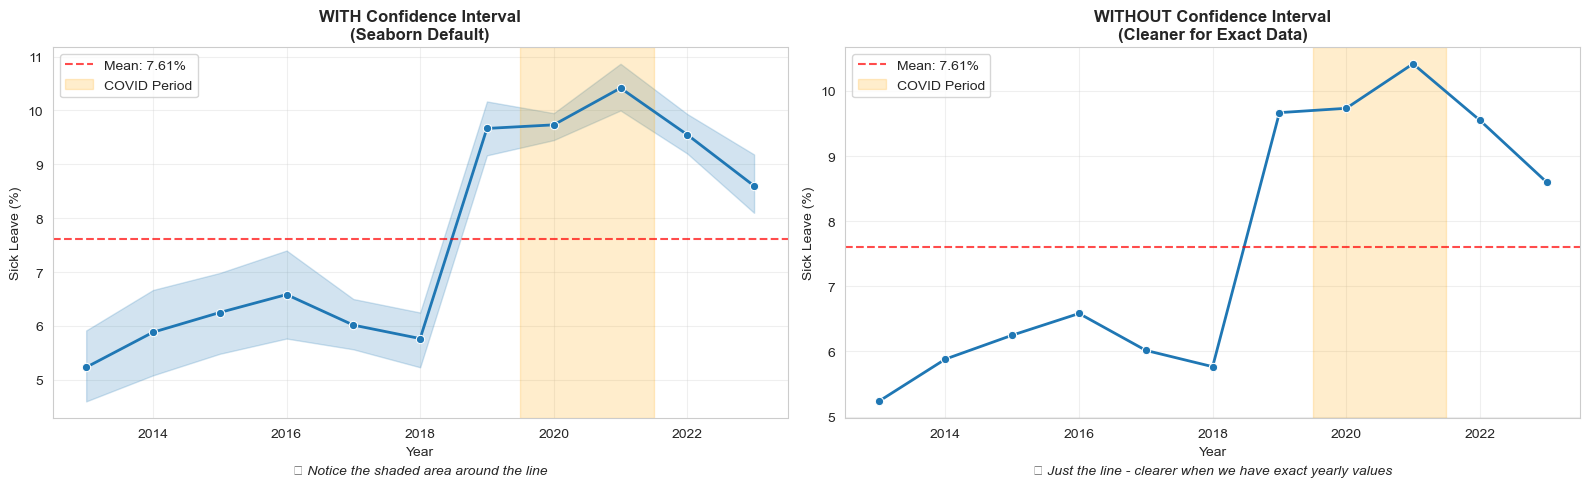

📊 Comparing the two plots:
   LEFT: Default seaborn adds shaded 'confidence interval'
        → Useful for estimated trends, but confusing here
   RIGHT: Clean line connecting exact data points
        → Better for our case (one exact value per year)

💡 For the rest of this workshop, we'll use the cleaner version (no CI)


In [ ]:
# Create TWO plots side-by-side to compare

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# PLOT 1: WITH confidence interval (default seaborn behavior)
sns.lineplot(
    data=df_all, 
    x='year', 
    y='sick_leave_percent',
    marker='o',
    linewidth=2,
    errorbar='ci',  # Show confidence interval (new parameter name)
    ax=ax1  # Plot on left axis
)
ax1.set_title('WITH Confidence Interval\n(Seaborn Default)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Sick Leave (%)')
ax1.set_xlabel('Year')
ax1.axhline(mean_sl, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_sl:.2f}%')
ax1.axvspan(2019.5, 2021.5, color='orange', alpha=0.2, label='COVID Period')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.text(0.5, -0.15, '↑ Notice the shaded area around the line', 
         ha='center', transform=ax1.transAxes, fontsize=10, style='italic')

# PLOT 2: WITHOUT confidence interval (cleaner for our data)
sns.lineplot(
    data=df_all, 
    x='year', 
    y='sick_leave_percent',
    marker='o',
    linewidth=2,
    errorbar=None,  # Turn OFF confidence interval (new parameter name)
    ax=ax2    # Plot on right axis
)
ax2.set_title('WITHOUT Confidence Interval\n(Cleaner for Exact Data)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Sick Leave (%)')
ax2.set_xlabel('Year')
ax2.axhline(mean_sl, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_sl:.2f}%')
ax2.axvspan(2019.5, 2021.5, color='orange', alpha=0.2, label='COVID Period')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.text(0.5, -0.15, '↑ Just the line - clearer when we have exact yearly values', 
         ha='center', transform=ax2.transAxes, fontsize=10, style='italic')

plt.tight_layout()
plt.show()

print("📊 Comparing the two plots:")
print("   LEFT: Default seaborn adds shaded 'confidence interval'")
print("        → Useful for estimated trends, but confusing here")
print("   RIGHT: Clean line connecting exact data points")
print("        → Better for our case (one exact value per year)")
print("\n💡 For the rest of this workshop, we'll use the cleaner version (no CI)")

In [ ]:
# Now create the final clean version for analysis
plt.figure(figsize=(12, 5))

sns.lineplot(
    data=df_all, 
    x='year', 
    y='sick_leave_percent', 
    marker='o',
    linewidth=2,
    errorbar=None  # No confidence interval for clean display (updated parameter)
)

plt.title('Sick Leave Trend (2013-2023)', fontsize=14, fontweight='bold')
plt.ylabel('Sick Leave (%)')
plt.xlabel('Year')
plt.axhline(mean_sl, color='red', linestyle='--', label=f'Mean: {mean_sl:.2f}%')
plt.axvspan(2019.5, 2021.5, color='orange', alpha=0.2, label='COVID Period')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("👀 What do you see?")
print("   • Pre-COVID (2013-2019): Stable around 6%")
print("   • COVID spike (2020-2021): Jump to 9%")
print("   • Recovery (2022-2023): Declining back")
print("\n💡 Key insight: The spike in 2020-2021 is clearly an outlier")

**Interpretation:**
The time series clearly shows a significant spike in sick leave during 2020-2021, corresponding to the COVID-19 pandemic. This is an **outlier** event. The mean is pulled upwards by these high values, which is why it's slightly higher than the median. For long-term planning, the median might be a more stable measure, but the mean reflects the actual average cost over this period.

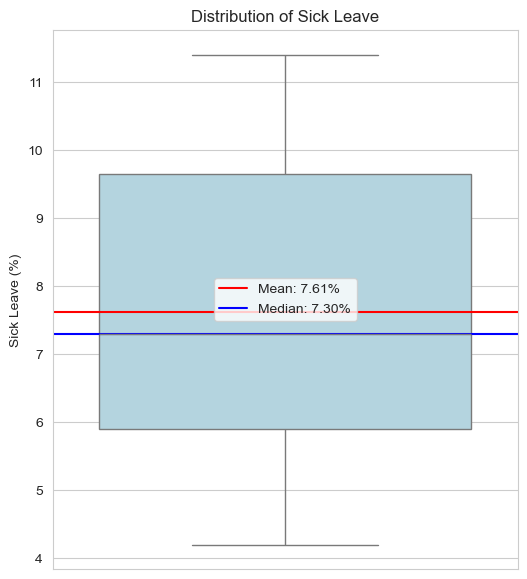

📦 Box Plot Guide:
   Box = Middle 50% of data
   Line in box = Median
   Whiskers = Normal range
   Dots outside = Outliers


In [48]:
# Box Plot: Shows distribution and outliers
plt.figure(figsize=(6, 7))
sns.boxplot(y=df_all['sick_leave_percent'], color='lightblue')
plt.axhline(mean_sl, color='red', label=f'Mean: {mean_sl:.2f}%')
plt.axhline(median_sl, color='blue', label=f'Median: {median_sl:.2f}%')
plt.title('Distribution of Sick Leave')
plt.ylabel('Sick Leave (%)')
plt.legend()
plt.show()

print("📦 Box Plot Guide:")
print("   Box = Middle 50% of data")
print("   Line in box = Median")
print("   Whiskers = Normal range")
print("   Dots outside = Outliers")

---
## ✍️ Part 3: Business Decisions (60 min - Your Turn!)

### 🎯 Task 1.1: Budget Planning (15 min)

**Question:** "What % should we budget for sick leave?"

**Calculate:**
1. 95% Confidence Interval
2. Pre-COVID vs Post-COVID averages
3. Your recommendation

In [50]:
# Calculate 95% Confidence Interval
n = len(df_all)
se = std_sl / np.sqrt(n)          # Standard Error
z = norm.ppf(0.975)                # Z-score for 95% = 1.96
ci_lower = mean_sl - z * se
ci_upper = mean_sl + z * se

# Compare periods
pre_covid = df_all[df_all['year'] < 2020]['sick_leave_percent'].mean()
covid = df_all[df_all['year'].isin([2020, 2021])]['sick_leave_percent'].mean()
post_covid = df_all[df_all['year'] >= 2022]['sick_leave_percent'].mean()

print(f"📊 Budget Analysis:")
print(f"   Mean: {mean_sl:.2f}%")
print(f"   Median: {median_sl:.2f}%")
print(f"   95% CI: [{ci_lower:.2f}%, {ci_upper:.2f}%]")
print(f"\n🦠 COVID Impact:")
print(f"   Pre-COVID: {pre_covid:.2f}%")
print(f"   COVID: {covid:.2f}%")
print(f"   Post-COVID: {post_covid:.2f}%")

📊 Budget Analysis:
   Mean: 7.61%
   Median: 7.30%
   95% CI: [7.12%, 8.10%]

🦠 COVID Impact:
   Pre-COVID: 6.49%
   COVID: 10.08%
   Post-COVID: 9.08%


**✏️ Your Recommendation:**

**Budget:** _____ %

**Justification:** [Why this number? Consider:
- Mean vs median (which is better for budgeting?)
- COVID impact (include or exclude?)
- Confidence interval (how certain are you?)
- Risk tolerance (conservative or aggressive?)]

### 🎯 Task 1.2: Staffing Buffers (15 min)

**Question:** "Which groups need bigger backup staff?"

**Method:** Calculate Coefficient of Variation (CV) = (SD ÷ Mean) × 100
- High CV = Unpredictable = Need large buffer
- Low CV = Stable = Small buffer okay

📊 Variability by Group (CV = Coefficient of Variation):
Group                          Mean%    CV%      Buffer Needed
------------------------------------------------------------
G2 Psykoterapeut               3.3      128.9    Large (15-20%)
G5 Logoped                     6.8      102.3    Large (15-20%)
G6 Dietist                     4.8      89.0     Large (15-20%)
E2 Tandhygienister             6.4      86.7     Large (15-20%)
A2 Barnmorskor                 5.3      84.2     Large (15-20%)
E1 Tandsköterskor m.fl.        6.2      80.9     Large (15-20%)
L1 Ledningsarbete              2.0      65.3     Large (15-20%)
G4 Arbetsterapeut              6.5      59.7     Large (15-20%)
G8 Övrig rehabiliteringspersonal 6.7      54.5     Large (15-20%)
G7 Kurator                     7.5      54.4     Large (15-20%)
H1 Biomedicinsk analytiker     6.0      53.3     Large (15-20%)
D1 Tandläkare                  5.3      53.2     Large (15-20%)
I1 Utbildning, kultur och fritid 5.2      52.8    

C:\Users\gimb\AppData\Local\Temp\ipykernel_42484\3896435775.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_prof, x='sick_leave_percent', y='group', palette='Set2')


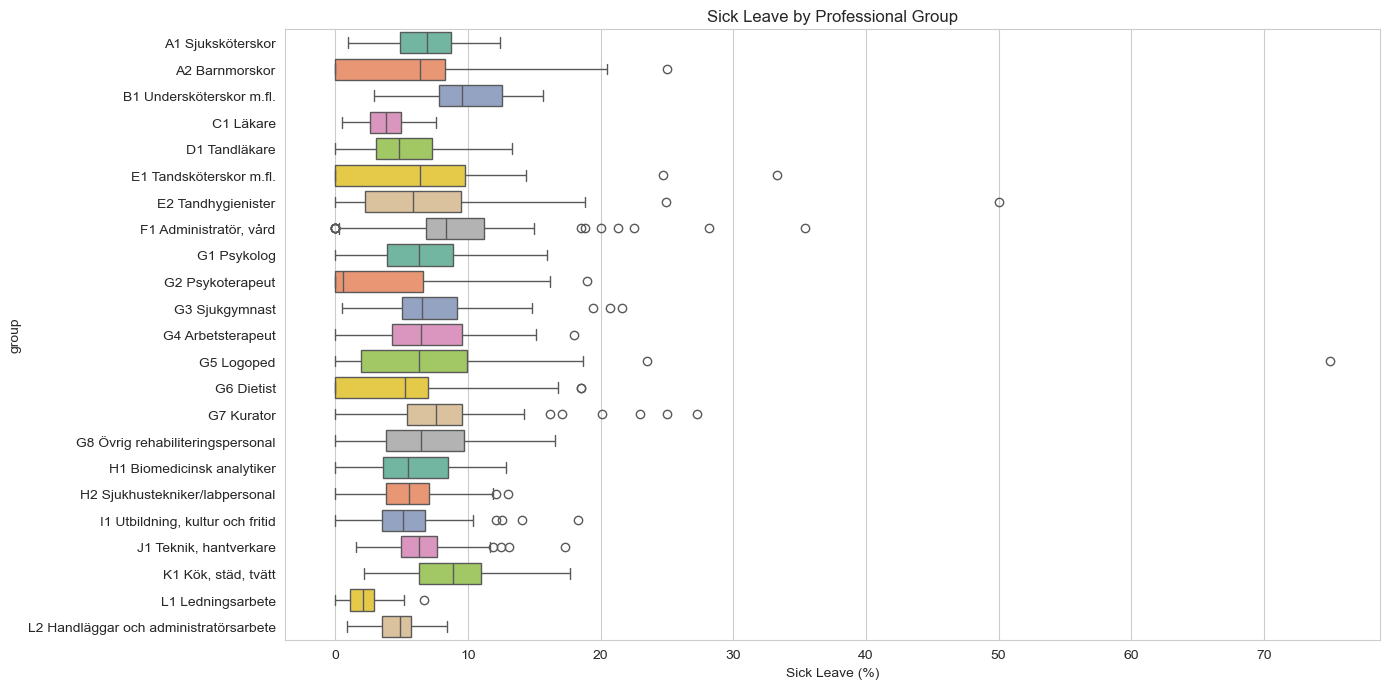

In [51]:
# Get data by professional group
df_prof = df_sick_leave[df_sick_leave['group'] != 'Samtliga yrkesgrupper']

# Calculate stats per group
stats = df_prof.groupby('group')['sick_leave_percent'].agg(['mean', 'std', 'min', 'max']).reset_index()
stats['cv'] = (stats['std'] / stats['mean']) * 100
stats = stats.sort_values('cv', ascending=False)

print("📊 Variability by Group (CV = Coefficient of Variation):")
print(f"{'Group':<30} {'Mean%':<8} {'CV%':<8} {'Buffer Needed'}")
print("-" * 60)
for _, row in stats.iterrows():
    buffer = "Large (15-20%)" if row['cv'] > 40 else "Medium (10-15%)" if row['cv'] > 25 else "Small (5-10%)"
    print(f"{row['group']:<30} {row['mean']:<8.1f} {row['cv']:<8.1f} {buffer}")

# Visualize
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_prof, x='sick_leave_percent', y='group', palette='Set2')
plt.title('Sick Leave by Professional Group')
plt.xlabel('Sick Leave (%)')
plt.tight_layout()
plt.show()

**✏️ Your Recommendations:**

**High CV groups** (need large buffers):
1. _____________ (CV=___%, Buffer=___%)
2. _____________ (CV=___%, Buffer=___%)

**Low CV groups** (small buffers okay):
1. _____________ (CV=___%, Buffer=___%)

**Justification:** [Why does high CV require larger buffers?]

### 🎯 Task 1.3: Specialty Selection (15 min)

**Question:** "Top 3 most reliable specialties?"

**Consider:** Mean sick leave, CV, trends

In [52]:
# Rank by mean sick leave
ranked = stats.sort_values('mean')

print("📊 Groups Ranked by Reliability (Lowest Sick Leave):")
print(f"{'Rank':<4} {'Group':<30} {'Mean%':<8} {'CV%':<8} {'Rating'}")
print("-" * 70)
for i, (_, row) in enumerate(ranked.iterrows(), 1):
    rating = "⭐⭐⭐" if row['mean'] < 5 else "⭐⭐" if row['mean'] < 7 else "⭐"
    print(f"{i:<4} {row['group']:<30} {row['mean']:<8.1f} {row['cv']:<8.1f} {rating}")

📊 Groups Ranked by Reliability (Lowest Sick Leave):
Rank Group                          Mean%    CV%      Rating
----------------------------------------------------------------------
1    L1 Ledningsarbete              2.0      65.3     ⭐⭐⭐
2    G2 Psykoterapeut               3.3      128.9    ⭐⭐⭐
3    C1 Läkare                      3.8      41.7     ⭐⭐⭐
4    L2 Handläggar och administratörsarbete 4.7      31.7     ⭐⭐⭐
5    G6 Dietist                     4.8      89.0     ⭐⭐⭐
6    I1 Utbildning, kultur och fritid 5.2      52.8     ⭐⭐
7    A2 Barnmorskor                 5.3      84.2     ⭐⭐
8    D1 Tandläkare                  5.3      53.2     ⭐⭐
9    H2 Sjukhustekniker/labpersonal 5.7      44.9     ⭐⭐
10   H1 Biomedicinsk analytiker     6.0      53.3     ⭐⭐
11   E1 Tandsköterskor m.fl.        6.2      80.9     ⭐⭐
12   E2 Tandhygienister             6.4      86.7     ⭐⭐
13   J1 Teknik, hantverkare         6.5      35.2     ⭐⭐
14   G1 Psykolog                    6.5      52.7     ⭐⭐
15 

**✏️ Your Top 3:**

1. _____________ (Mean=___%, CV=___%) - Why?
2. _____________ (Mean=___%, CV=___%) - Why?
3. _____________ (Mean=___%, CV=___%) - Why?

**Decision logic:** [Did you only consider mean, or also CV and trends?]

### 🎯 Task 1.4: Trend Analysis (15 min)

**Question:** "Are rates improving or worsening?"

**Method:** Compare pre-COVID baseline to post-COVID current

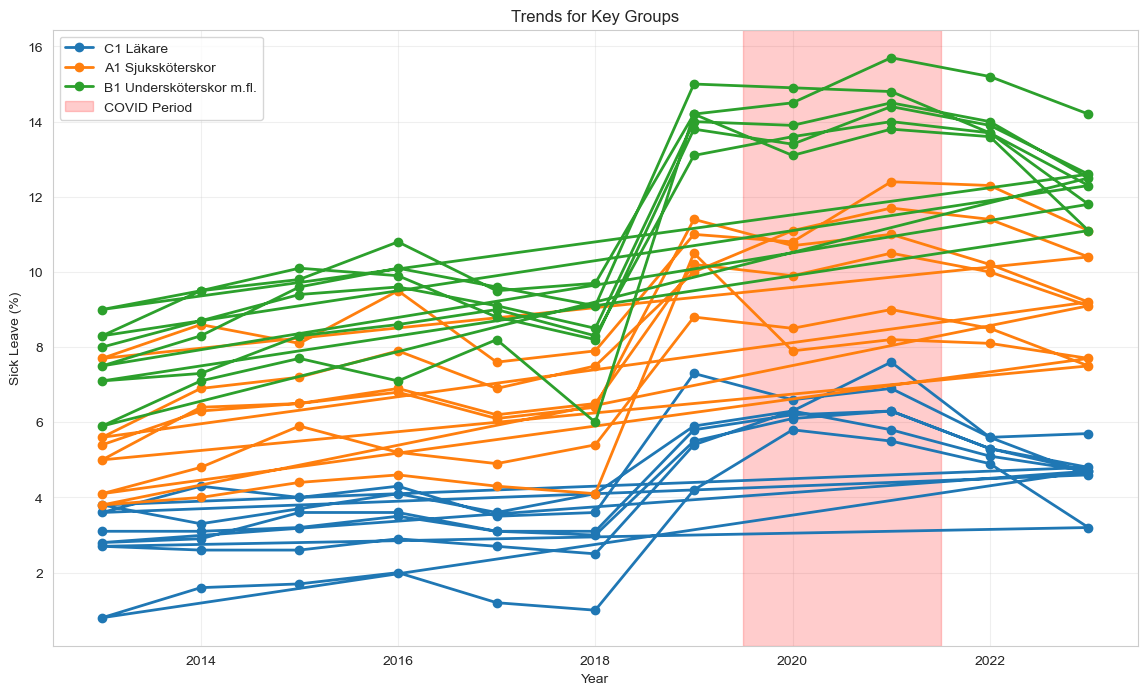

📊 Trend Analysis:
Group                          Pre-COVID    Post-COVID   Trend
----------------------------------------------------------------------
C1 Läkare                      3.4          5.0          ↘️ Worsening
A1 Sjuksköterskor              6.8          9.6          ↘️ Worsening
B1 Undersköterskor m.fl.       9.4          13.2         ↘️ Worsening


In [53]:
# Select key groups for trend analysis
key_groups = ['C1 Läkare', 'A1 Sjuksköterskor', 'B1 Undersköterskor m.fl.']
df_key = df_prof[
    (df_prof['group'].isin(key_groups)) &
    (df_prof['gender'] == 'Both')
]

# Plot trends
plt.figure(figsize=(14, 8))
for group in key_groups:
    data = df_key[df_key['group'] == group]
    plt.plot(data['year'], data['sick_leave_percent'], marker='o', label=group, linewidth=2)

plt.axvspan(2019.5, 2021.5, color='red', alpha=0.2, label='COVID Period')
plt.title('Trends for Key Groups')
plt.ylabel('Sick Leave (%)')
plt.xlabel('Year')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate trend statistics
print("📊 Trend Analysis:")
print(f"{'Group':<30} {'Pre-COVID':<12} {'Post-COVID':<12} {'Trend'}")
print("-" * 70)
for group in key_groups:
    data = df_key[df_key['group'] == group]
    pre = data[data['year'] <= 2019]['sick_leave_percent'].mean()
    post = data[data['year'] >= 2022]['sick_leave_percent'].mean()
    trend = "↗️ Improving" if post < pre else "↘️ Worsening" if post > pre else "→ Stable"
    print(f"{group:<30} {pre:<12.1f} {post:<12.1f} {trend}")

**✏️ Your 5-Year Recommendation:**

**Overall trend:** [Improving/Stable/Worsening]

**Budget planning:**
- Years 1-2: _____% (because...)
- Years 3-5: _____% (because...)

**Based on trends, should you revise your Task 1.1 budget?** [Yes/No, why?]

---
## 🎯 Part 4: Wrap-Up (10 min)

### What You Learned

**🐍 Python:**
- Importing libraries, loading Excel files
- Filtering data, calculating statistics
- Creating charts

**📊 Statistics:**
- Mean vs median, when to use each
- Standard deviation, coefficient of variation
- Outlier detection, confidence intervals

**💼 Business:**
- Evidence-based budgeting
- Risk assessment through variability
- Multi-factor decision making

### Key Insights

**1. Context matters** - Same data, different interpretations depending on stakeholder
**2. Outliers require judgment** - Include COVID or exclude? Depends on your assumptions
**3. No perfect answer** - Good decisions are justified, not just "correct"

### Next Week: Workshop 2

You'll add **salary data** → analyze **cost vs reliability trade-offs** → face **stakeholder conflicts**

**Prepare:** Review your Task 1.1 budget recommendation - you'll revisit it!

### Reflection

**Most challenging aspect:** [Your thoughts]

**Biggest insight:** [Your thoughts]

**Confidence in recommendations (1-10):** ___ because [your reasoning]

## 📋 Deliverables

**Submit (if required):**
1. Completed notebook with all tasks
2. Your recommendations for all 4 tasks
3. Reflection paragraph

**Self-Check:**
- [ ] I can calculate mean, median, SD
- [ ] I can create time series and box plots
- [ ] I can identify outliers
- [ ] I can justify decisions with data
- [ ] I understand method limitations